In [1]:
import numpy as np
from matplotlib import pylab as plt
from queue import Queue, PriorityQueue
import random
from sklearn.datasets import load_boston

np.seterr(over='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [0]:
def levenstein_dist(s1, s2):
  A = np.zeros((len(s1) + 1, len(s2) + 1))
  A[0, :] = np.arange(len(s2) + 1)
  A[:, 0] = np.arange(len(s1) + 1)
  for i in range(1, len(s1) + 1):
    for j in range(1, len(s2) + 1):
      A[i][j] = min(A[i - 1][j] + 1, A[i][j - 1] + 1, A[i-1][j-1] + (0 if s1[i-1] == s2[j-1] else 1))
  return A[-1][-1]

In [0]:
class WANN:
  class Node:
    def __init__(self, function, parent):
      self.children = PriorityQueue()
      self.function = function
      self.parent = parent

    def __str__(self):
      if self.children.empty():
        return self.function.function.__name__ + '(x)'
      return self.function.function.__name__ + '(' + ', '.join([str(child) for child in self.children.queue]) + ')'

    def str_dfs(self):
      return str(self.function.priority_key) + ''.join([child.str_dfs() for child in self.children.queue])

    def __lt__(self, other):
      return self.function < other.function

    def replace_with_random_subtree(self, nodes_num, childs_num_bounds, function_list):
      new_subtree = WANN()
      new_subtree.generate(nodes_num, childs_num_bounds, function_list)
      new_subtree.top_node.parent = self.parent
      self.parent.children.queue.remove(self)
      self.parent.children.put(new_subtree.top_node)

    def calculate(self, x, param):
      if self.children.empty():
        return self.function.function(param*np.sum(x))
      return self.function.function(param*np.sum([child.calculate(x, param) for child in self.children.queue]))

  def __init__(self):
    self.top_node = -1

  def copy(self):
    return self.get_subtree_copy(self.top_node)

  def get_subtree_copy(self, top_node):
    q = Queue()
    new_wann = WANN()
    new_wann.top_node = self.Node(top_node.function, -1)
    for child in top_node.children.queue:
      q.put((child, new_wann.top_node))
    while not q.empty():
      node, parent = q.get()
      new_node = self.Node(node.function, parent)
      parent.children.put(new_node)
      for child in node.children.queue:
        q.put((child, new_node))
    return new_wann

  def count_nodes(self):
    nodes_num = 0
    q = Queue()
    q.put(self.top_node)
    while not q.empty():
      node = q.get()
      nodes_num += 1
      for child in node.children.queue:
        q.put(child)
    return nodes_num


  def __str__(self):
    return str(self.top_node)

  def str_dfs(self):
      return self.top_node.str_dfs()

  def dist(self, other):
    return levenstein_dist(self.str_dfs(), other.str_dfs())

  def select_random_node(self):
    q = Queue()
    nodes = []
    for child in self.top_node.children.queue:
      q.put(child)
    while not q.empty():
      node = q.get()
      nodes.append(node)
      for child in node.children.queue:
        q.put(child)
    return random.choice(nodes)

  def mutate(self, nodes_num, childs_num_bounds, function_list):
    new_wann = self.copy()
    node = new_wann.select_random_node()
    node.replace_with_random_subtree(nodes_num, childs_num_bounds, function_list)
    return new_wann

  def crossover(self, other):
    new_wann = self.copy()
    node1 = new_wann.select_random_node()
    node2 = other.select_random_node()
    new_subtree = other.get_subtree_copy(node2)
    new_subtree.top_node.parent = node1.parent
    node1.parent.children.queue.remove(node1)
    node1.parent.children.put(new_subtree.top_node)
    return new_wann
  
  def generate(self, nodes_num, childs_num_bounds, function_list):
    if type(nodes_num) == type(tuple):
      nodes_num = np.random.randint(nodes_num[0], nodes_num[1] + 1)
    length = 1
    self.top_node = self.Node(np.random.choice(function_list), -1)
    q = []
    q.append(self.top_node)
    while length < nodes_num:
      node = random.choice(q)
      q.remove(node)
      childs_num = np.random.randint(childs_num_bounds[0], childs_num_bounds[1] + 1)
      for _ in range(childs_num):
        new_child = self.Node(np.random.choice(function_list), node)
        q.append(new_child)
        node.children.put(new_child)
      length += childs_num
    return self

  def calculate(self, x, param):
    try:
      return self.top_node.calculate(x, param)
    except:
      return np.inf

  def err(self, X, Y, params):
    error = 0
    for param in params:
      error += np.linalg.norm(Y - [self.calculate(x, param) for x in X])
    return error/len(params)

  def optimise_param(self, X, Y, params):
    optimal = params[0]
    min_err = np.inf
    for param in params:
      error = self.err(X, Y, [param])
      if error < min_err:
        min_err = error
        optimal = param
    return optimal, min_err

In [0]:
class Function:
  def __init__(self, function, priority_key):
    self.function = function
    self.priority_key = priority_key
  
  def __lt__(self, other):
    return self.priority_key < other.priority_key

In [0]:
def diam(T):
  d = 0
  for t1 in T:
    for t2 in T:
      d = max(d, t1.dist(t2))
  return d

def genetic_alg(X, Y, params, population_size, nodes_num, childs_bounds, mutation_nodes_num, function_list, mutations_num, crossovers_num, stagnation_diam, eps, max_epochs=100, return_history=False):
  population = [WANN().generate(nodes_num, childs_bounds, function_list) for _ in range(population_size)]
  epoch = 1
  errs = Queue()
  history = []
  while population[0].err(X, Y, params) > eps and epoch <= max_epochs:
    print(str(epoch) + " epoch starting...")
    #print(population[0].err(X, Y, params))
    epoch += 1
    #mutated = [wann.mutate(mutation_nodes_num, childs_bounds, function_list) for wann in random.sample(population, mutations_num)]
    mutated = [wann.mutate(mutation_nodes_num, childs_bounds, function_list) for wann in population[population_size//2:]]
    crossovered = []
    for _ in range(crossovers_num):
      parents = random.sample(population[:population_size//2], 2)
      crossovered.append(parents[0].crossover(parents[1]))
    population = population + mutated + crossovered
    population = sorted(population, key=lambda wann: wann.err(X, Y, params))[:population_size]
    """
    if diam(population) <= stagnation_diam:  #stagnation detected!
      for wann in population[population_size//2:]:  #replace the wordst ones with generated
        wann.generate(nodes_num, childs_bounds, function_list)
    """
    error = population[0].err(X, Y, params)
    errs.put(error)
    if errs.qsize() == 6:
      if error/errs.get() > 0.9:
        for wann in population[population_size//2:]:  #replace the wordst ones with generated
          wann.generate(nodes_num, childs_bounds, function_list)
    if return_history:
      history.append(error)
  if return_history:
    return population[0], history
  return population[0]

In [0]:
functions = [np.sin, np.cos]
k = 0
function_list = []
for f in functions:
  function_list.append(Function(f, k))
  k += 1

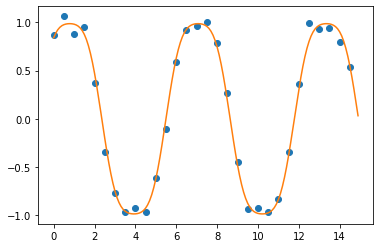

In [18]:
X = np.arange(0, 15, 0.5)
Y = np.sin(np.cos(X) + np.sin(X)) + np.random.randn(30)/15
plt.plot(X, Y, 'o')
plt.plot(np. arange(0, 15, 0.1), np.sin(np.cos(np.arange(0, 15, 0.1)) + np.sin(np.arange(0, 15, 0.1))))

In [8]:
wann = genetic_alg(X, Y, [1], 10, 6, (1, 3), 3, function_list, 3, 3, 0, 1)

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...


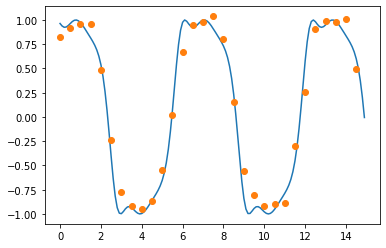

In [9]:
x = np.arange(0, 15, 0.1)
plt.plot(x, [wann.calculate(i, 1) for i in x])
plt.plot(X, Y, 'o')

In [0]:
def sqr(x):
  return x**2

def sigmoid(x):
  return 1/(1 + np.exp(-x))

def lin1(x):
  return x

def lin2(x):
  return 2*x

def lin05(x):
  return 0.5*x

functions = [np.sin, np.cos, sqr, sigmoid, np.exp, lin1, lin2, lin05]
k = 0
function_list = []
for f in functions:
  function_list.append(Function(f, k))
  k += 1

In [0]:
X, y = load_boston(return_X_y=True)
X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

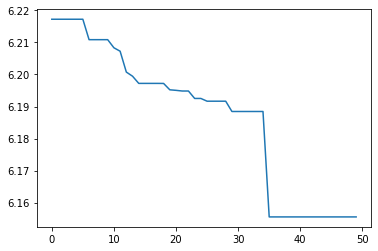

In [9]:
wann, history = genetic_alg(X_train, y_train, [-2, -1, 1, 2], 10, 10, (1, 4), 3, function_list, 5, 5, 0, 0, 50, True)
plt.plot(np.log(history))
print(wann.optimise_param(X_train, y_train, np.arange(-10, 10, 0.5)))

In [10]:
print(wann.err(X_test, y_test, [3]))

70.72846067351628


In [16]:
print(wann)
print([wann.calculate(x, 3) for x in X_test])
print(y_test)

exp(sigmoid(lin1(x), lin2(x), lin1(x)))
[20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668, 20.085536923187668,

In [12]:
w = np.linalg.pinv(X_train)@y_train
print(np.linalg.norm(X_train@w - y_train))

97.07846201242472


In [0]:
X = np.arange(0, 15, 0.5)
Y = np.sin(np.cos(X) + np.sin(X)) + np.random.randn(30)/15

In [19]:
wann1 = WANN()
wann2 = WANN()
wann = WANN()
params = [1]
a = 0
b = 0
c = 0
aa = 0
bb = 0
cc = 0

for _ in range(10000):
  wann1.generate(10, (1, 3), function_list)
  wann2.generate(10, (1, 3), function_list)
  wann.generate(10, (1, 3), function_list)
  child = wann1.crossover(wann2)
  error = wann.err(X, Y, params)
  error1 = wann1.err(X, Y, params)
  error2 = wann2.err(X, Y, params)
  if error > max(error1, error2):
    a += 1
  elif error >= min(error1, error2):
    b += 1
  else:
    c += 1
  error = child.err(X, Y, params)
  if error > max(error1, error2):
    aa += 1
  elif error >= min(error1, error2):
    bb += 1
  else:
    cc += 1
print(a, b, c)
print(aa, bb, cc)

3042 3682 3276
1694 5917 2389


1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

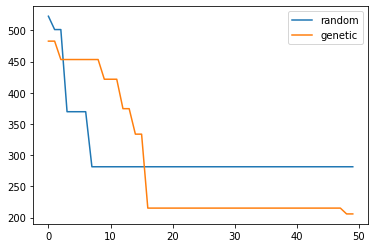

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

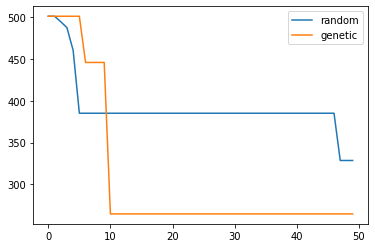

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

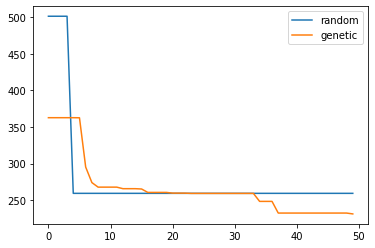

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

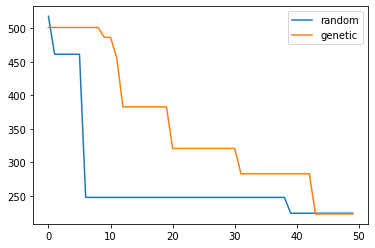

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

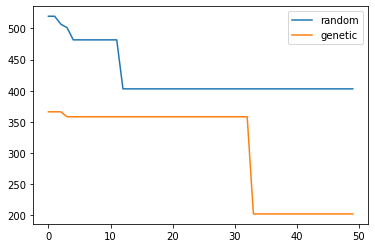

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

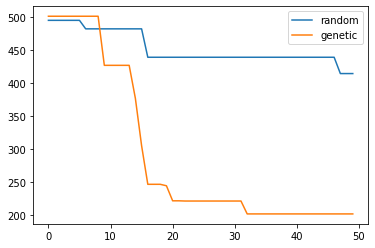

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

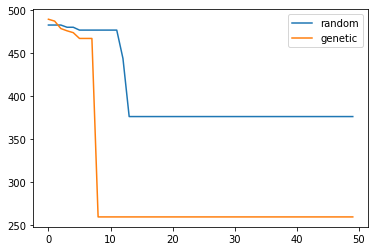

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

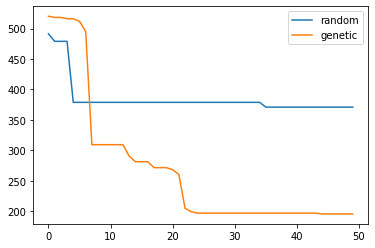

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

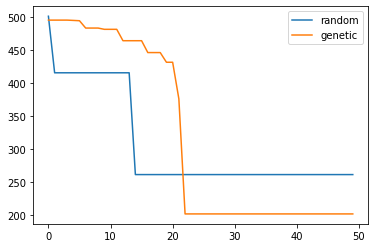

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

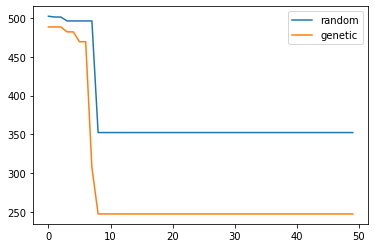

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

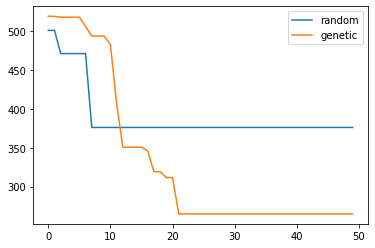

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

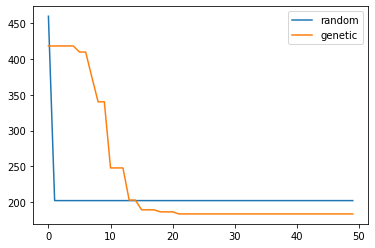

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

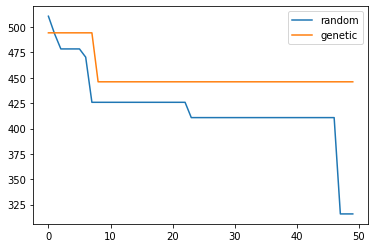

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

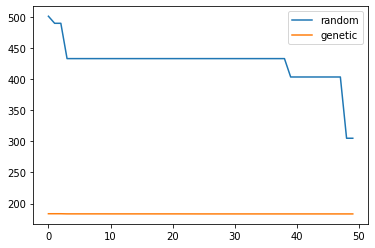

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

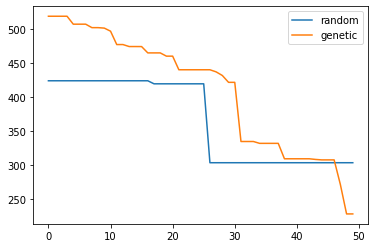

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

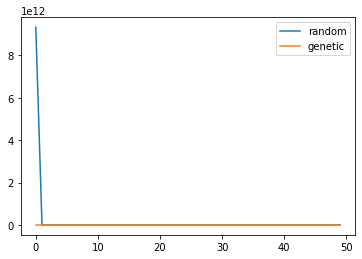

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

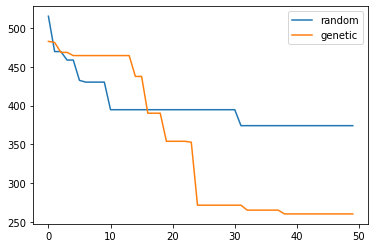

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

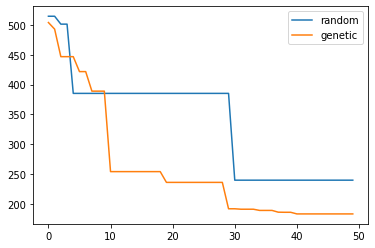

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

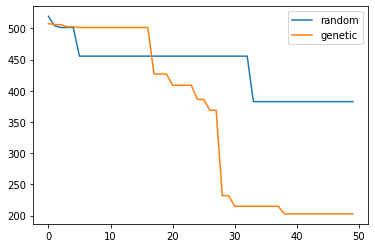

1 epoch starting...
2 epoch starting...
3 epoch starting...
4 epoch starting...
5 epoch starting...
6 epoch starting...
7 epoch starting...
8 epoch starting...
9 epoch starting...
10 epoch starting...
11 epoch starting...
12 epoch starting...
13 epoch starting...
14 epoch starting...
15 epoch starting...
16 epoch starting...
17 epoch starting...
18 epoch starting...
19 epoch starting...
20 epoch starting...
21 epoch starting...
22 epoch starting...
23 epoch starting...
24 epoch starting...
25 epoch starting...
26 epoch starting...
27 epoch starting...
28 epoch starting...
29 epoch starting...
30 epoch starting...
31 epoch starting...
32 epoch starting...
33 epoch starting...
34 epoch starting...
35 epoch starting...
36 epoch starting...
37 epoch starting...
38 epoch starting...
39 epoch starting...
40 epoch starting...
41 epoch starting...
42 epoch starting...
43 epoch starting...
44 epoch starting...
45 epoch starting...
46 epoch starting...
47 epoch starting...
48 epoch starting...
4

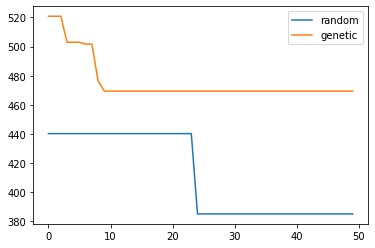

In [8]:
for _ in range(20):
  history1 = []
  histiry2 = genetic_alg(X_train, y_train, [1], 10, 10, (1, 3), 4, function_list, 5, 5, 0, 0, 50, True)[1]
  min_err = np.inf
  for _ in range(1, 751):
    wann = WANN().generate(10, (1, 3), function_list)
    min_err = min(wann.err(X_train, y_train, [1]), min_err)
    if _%15 == 0:
      history1.append(min_err)
  plt.plot(history1, label="random")
  plt.plot(histiry2, label="genetic")
  plt.legend()
  plt.show()

In [22]:
print(np.seterr(over='raise'))

def f():
  return np.exp(1000)

def g():
  try:
    return f()
  except:
    return "oh no"

g()

{'divide': 'warn', 'over': 'raise', 'under': 'ignore', 'invalid': 'warn'}


'oh no'